In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import gzip

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

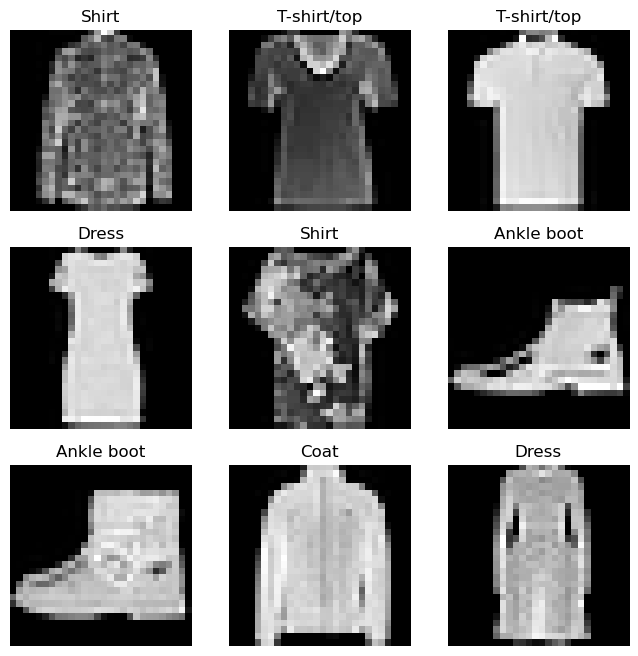

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [36]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [40]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306957  [   64/60000]
loss: 2.296147  [ 6464/60000]
loss: 2.273746  [12864/60000]
loss: 2.266272  [19264/60000]
loss: 2.250971  [25664/60000]
loss: 2.217182  [32064/60000]
loss: 2.228909  [38464/60000]
loss: 2.195453  [44864/60000]
loss: 2.188948  [51264/60000]
loss: 2.160021  [57664/60000]
Test Error: 
 Accuracy: 42.7%, Avg loss: 2.155762 

Epoch 2
-------------------------------
loss: 2.167244  [   64/60000]
loss: 2.161547  [ 6464/60000]
loss: 2.097712  [12864/60000]
loss: 2.116953  [19264/60000]
loss: 2.079131  [25664/60000]
loss: 2.011789  [32064/60000]
loss: 2.039007  [38464/60000]
loss: 1.964299  [44864/60000]
loss: 1.955008  [51264/60000]
loss: 1.901619  [57664/60000]
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.893165 

Epoch 3
-------------------------------
loss: 1.921449  [   64/60000]
loss: 1.903921  [ 6464/60000]
loss: 1.772288  [12864/60000]
loss: 1.819563  [19264/60000]
loss: 1.727786  [25664/60000]
loss: 1.663390  [32064/600

In [52]:
torch.save(model.state_dict(), f"../models/fashion-mnist-{device}.pth")
print(f"Saved PyTorch Model State to ../models/fashion-mnist-{device}.pth")

Saved PyTorch Model State to ../models/fashion-mnist-cpu.pth


In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(f"../models/fashion-mnist-{device}.pth"))

<All keys matched successfully>

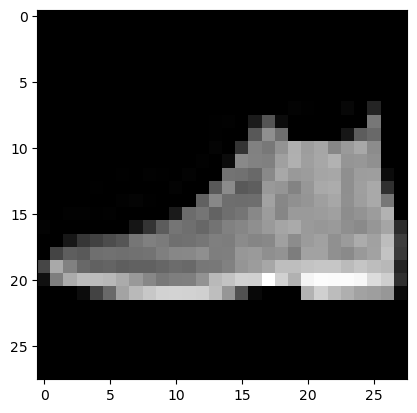

Predicted: "Ankle boot", Actual: "Ankle boot"


In [16]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

plt.imshow(x.squeeze(), cmap="gray")
plt.show()

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [17]:
save_image(x, "../data/fashion-mnist/0.png")

In [18]:
print(f"Shape of input image: {x.shape}")
print(f"Input image center: {x[:,12:16,12:16]}")

Shape of input image: torch.Size([1, 28, 28])


Input image center: tensor([[[0.0000, 0.0000, 0.4510, 0.4471],
         [0.0000, 0.3490, 0.5451, 0.3529],
         [0.3843, 0.5333, 0.4314, 0.4275],
         [0.4588, 0.3882, 0.4353, 0.4588]]], device='cuda:0')


In [19]:
flat_image = model.flatten(x)
flat_image_center = torch.stack((
    flat_image[:,348:352][0],
    flat_image[:,376:380][0],
    flat_image[:,404:408][0],
    flat_image[:,432:436][0]))
print(f"Shape of flat image: {flat_image.shape}")
print(f"Flat image center: {flat_image_center}")

Shape of flat image: torch.Size([1, 784])
Flat image center: tensor([[0.0000, 0.0000, 0.4510, 0.4471],
        [0.0000, 0.3490, 0.5451, 0.3529],
        [0.3843, 0.5333, 0.4314, 0.4275],
        [0.4588, 0.3882, 0.4353, 0.4588]], device='cuda:0')


In [20]:
layer0_weight = model.get_parameter("linear_relu_stack.0.weight")
layer0_bias = model.get_parameter("linear_relu_stack.0.bias")

print(f"layer 0 weight - Shape: {layer0_weight.shape} - {layer0_weight}\n")
print(f"layer 0 bias - Shape: {layer0_bias.shape} - {layer0_bias}")

layer 0 weight - Shape: torch.Size([512, 784]) - Parameter containing:
tensor([[ 0.0166, -0.0215, -0.0213,  ...,  0.0249, -0.0333,  0.0195],
        [ 0.0019,  0.0064, -0.0097,  ..., -0.0314,  0.0137, -0.0085],
        [-0.0215, -0.0111, -0.0079,  ...,  0.0136, -0.0033,  0.0346],
        ...,
        [ 0.0033,  0.0057, -0.0331,  ...,  0.0188,  0.0275, -0.0074],
        [-0.0124, -0.0270, -0.0229,  ..., -0.0219, -0.0196, -0.0023],
        [-0.0082,  0.0086,  0.0155,  ...,  0.0073, -0.0347, -0.0143]],
       device='cuda:0', requires_grad=True)

layer 0 bias - Shape: torch.Size([512]) - Parameter containing:
tensor([ 2.6567e-02,  6.3177e-03,  6.0578e-03,  3.2456e-03,  4.2460e-02,
         2.5497e-03, -7.8638e-03, -1.1674e-03,  2.7715e-02,  1.0238e-02,
        -2.8850e-02,  2.2727e-02,  8.7578e-03, -1.7382e-02,  2.3547e-02,
        -1.5281e-02,  2.9908e-02,  8.9176e-03, -5.5175e-03,  2.0215e-02,
         1.0769e-02,  2.2023e-02,  3.1302e-02, -1.2984e-02, -1.3096e-02,
         6.9134e-03, 

In [21]:
layer0 = model.linear_relu_stack[0]
hidden0 = layer0(flat_image)

print(f"Shape of hidden 0: {hidden0.shape}")
print(f"Hidden 0: {hidden0}")

Shape of hidden 0: torch.Size([1, 512])
Hidden 0: tensor([[ 4.7023e-01,  5.3192e-01,  3.9917e-02,  6.2203e-01,  5.4609e-01,
          7.7525e-02,  3.9193e-01,  4.3129e-01,  2.1754e-01, -1.0306e-02,
         -9.5101e-02,  3.7093e-01,  2.0274e-01,  9.1209e-01, -3.1995e-01,
          1.3447e-01,  2.9983e-01,  3.3304e-01,  1.6213e-01,  1.7942e-01,
         -2.0478e-01, -7.1918e-02,  1.7913e-01,  3.6763e-01, -1.7919e-02,
          1.1502e+00,  7.4470e-01,  1.0965e-01,  3.4227e-02,  1.4799e-01,
          3.1840e-01, -1.1400e-01, -3.8621e-03, -1.6962e-03,  3.1034e-01,
         -1.9679e-01,  5.1626e-02, -1.6058e-01,  2.2335e-01,  3.8226e-01,
          3.6692e-01, -7.9282e-02, -2.1028e-01, -1.0165e-01, -8.0525e-02,
          3.6647e-01, -1.9063e-01, -4.1263e-04,  2.6500e-01,  3.2607e-02,
         -1.8676e-01,  3.1039e-01,  5.7008e-01,  6.8967e-01, -5.1019e-02,
         -1.4922e-01, -7.0927e-02,  5.9328e-02, -1.9945e-01,  7.5197e-01,
          3.4744e-01,  8.5129e-02, -3.0855e-01, -3.8942e-01, -

In [22]:
torch.set_printoptions(precision=15)
print(hidden0[0][0])
print(flat_image @ layer0_weight[0] + layer0_bias[0])
torch.set_printoptions(precision=4)

tensor(0.470225989818573, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.470225989818573], device='cuda:0', grad_fn=<AddBackward0>)


In [23]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer0-weight.gz", mode="wb") as f
):
    f.write(layer0_weight.cpu().numpy().tobytes())

In [24]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer0-bias.gz", mode="wb") as f
):
    f.write(layer0_bias.cpu().numpy().tobytes())

In [25]:
layer1 = model.linear_relu_stack[1]
hidden1 = layer1(hidden0)

print(f"Shape of hidden 1: {hidden1.shape}")
print(f"Hidden 1: {hidden1}")

Shape of hidden 1: torch.Size([1, 512])
Hidden 1: tensor([[4.7023e-01, 5.3192e-01, 3.9917e-02, 6.2203e-01, 5.4609e-01, 7.7525e-02,
         3.9193e-01, 4.3129e-01, 2.1754e-01, 0.0000e+00, 0.0000e+00, 3.7093e-01,
         2.0274e-01, 9.1209e-01, 0.0000e+00, 1.3447e-01, 2.9983e-01, 3.3304e-01,
         1.6213e-01, 1.7942e-01, 0.0000e+00, 0.0000e+00, 1.7913e-01, 3.6763e-01,
         0.0000e+00, 1.1502e+00, 7.4470e-01, 1.0965e-01, 3.4227e-02, 1.4799e-01,
         3.1840e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1034e-01, 0.0000e+00,
         5.1626e-02, 0.0000e+00, 2.2335e-01, 3.8226e-01, 3.6692e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6647e-01, 0.0000e+00, 0.0000e+00,
         2.6500e-01, 3.2607e-02, 0.0000e+00, 3.1039e-01, 5.7008e-01, 6.8967e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9328e-02, 0.0000e+00, 7.5197e-01,
         3.4744e-01, 8.5129e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.7340e-01, 1.1903e-01, 6.0573e-01, 5.

In [27]:
layer2_weight = model.get_parameter("linear_relu_stack.2.weight")
layer2_bias = model.get_parameter("linear_relu_stack.2.bias")

print(f"layer 2 weight - Shape: {layer2_weight.shape} - {layer2_weight}\n")
print(f"layer 2 bias - Shape: {layer2_bias.shape} - {layer2_bias}")

layer 2 weight - Shape: torch.Size([512, 512]) - Parameter containing:
tensor([[ 0.0329,  0.0391,  0.0297,  ..., -0.0288, -0.0236, -0.0275],
        [ 0.0211, -0.0174,  0.0346,  ...,  0.0448, -0.0248,  0.0167],
        [-0.0371,  0.0114, -0.0073,  ...,  0.0108, -0.0244,  0.0088],
        ...,
        [-0.0210,  0.0206, -0.0281,  ...,  0.0027,  0.0027,  0.0196],
        [-0.0311, -0.0326, -0.0292,  ..., -0.0330,  0.0185,  0.0421],
        [-0.0306, -0.0017,  0.0008,  ..., -0.0063,  0.0034, -0.0295]],
       device='cuda:0', requires_grad=True)

layer 2 bias - Shape: torch.Size([512]) - Parameter containing:
tensor([ 9.1274e-03,  5.8128e-02, -1.7652e-02, -2.4247e-02, -2.9891e-02,
        -3.3367e-02, -3.5809e-02, -3.3992e-02,  2.4661e-02, -1.9930e-02,
        -1.2436e-02,  9.8851e-03,  4.6622e-02,  4.2768e-03, -2.8191e-02,
        -2.8528e-02, -2.8024e-02, -3.4333e-02,  1.9791e-02,  4.0003e-02,
        -3.5044e-02,  3.3869e-04,  9.7828e-03, -3.1343e-02, -3.6365e-03,
        -3.4474e-02, 

In [28]:
layer2 = model.linear_relu_stack[2]
hidden2 = layer2(hidden1)

print(f"Shape of hidden 2: {hidden2.shape}")
print(f"Hidden 2: {hidden2}")

Shape of hidden 2: torch.Size([1, 512])
Hidden 2: tensor([[-2.7726e-01, -3.8191e-01,  1.3590e-01, -1.4818e-01, -6.9505e-02,
         -8.9749e-02,  5.2888e-01, -1.7615e-01,  1.7339e-01,  2.4589e-01,
         -2.2440e-01, -6.3151e-02,  7.5973e-01,  2.8454e-01, -8.5518e-02,
          2.3786e-03, -2.5390e-01,  2.2738e-01, -4.0623e-01,  7.1790e-01,
         -1.2537e-01, -1.6058e-01, -2.0986e-01,  1.0935e-01,  3.3992e-01,
          1.3117e-02, -1.6093e-01, -2.2908e-01, -4.7063e-01, -1.0604e-01,
         -1.9042e-01,  9.3610e-01,  7.6163e-01, -1.1777e-01,  7.1609e-02,
         -2.0978e-01, -9.0930e-02,  2.8581e-01,  3.8592e-01,  5.4955e-01,
         -1.2409e-01,  5.8258e-01,  1.3629e-01,  3.2620e-01,  5.1460e-01,
          7.5817e-02, -6.3853e-02,  2.3183e-01,  9.0415e-02,  8.0219e-01,
          2.4799e-02,  8.9640e-04, -4.7402e-02, -3.7522e-01,  1.3352e-01,
         -1.3034e-01, -3.3467e-02, -5.1212e-03,  3.7537e-01,  1.2864e+00,
         -5.8606e-01, -5.3883e-02,  1.7480e-01,  4.0973e-01,  

In [29]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer2-weight.gz", mode="wb") as f
):
    f.write(layer2_weight.cpu().numpy().tobytes())

In [30]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer2-bias.gz", mode="wb") as f
):
    f.write(layer2_bias.cpu().numpy().tobytes())

In [31]:
layer3 = model.linear_relu_stack[3]
hidden3 = layer3(hidden2)

print(f"Shape of hidden 3: {hidden3.shape}")
print(f"Hidden 3: {hidden3}")

Shape of hidden 3: torch.Size([1, 512])
Hidden 3: tensor([[0.0000e+00, 0.0000e+00, 1.3590e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         5.2888e-01, 0.0000e+00, 1.7339e-01, 2.4589e-01, 0.0000e+00, 0.0000e+00,
         7.5973e-01, 2.8454e-01, 0.0000e+00, 2.3786e-03, 0.0000e+00, 2.2738e-01,
         0.0000e+00, 7.1790e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0935e-01,
         3.3992e-01, 1.3117e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.3610e-01, 7.6163e-01, 0.0000e+00, 7.1609e-02, 0.0000e+00,
         0.0000e+00, 2.8581e-01, 3.8592e-01, 5.4955e-01, 0.0000e+00, 5.8258e-01,
         1.3629e-01, 3.2620e-01, 5.1460e-01, 7.5817e-02, 0.0000e+00, 2.3183e-01,
         9.0415e-02, 8.0219e-01, 2.4799e-02, 8.9640e-04, 0.0000e+00, 0.0000e+00,
         1.3352e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7537e-01, 1.2864e+00,
         0.0000e+00, 0.0000e+00, 1.7480e-01, 4.0973e-01, 3.7397e-01, 0.0000e+00,
         7.5622e-01, 1.4182e-01, 0.0000e+00, 5.2727e-02, 0.